In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from datasets import DataCifar10
from models import ThreeLayerConvNet
from models.layers import Conv, ConvNaive, MaxPool, MaxPoolNaive
from optimers import OptimerAdam, OptimerSGD
from utils import check_rel_error, check_gradient, check_accuracy, show_training_info

In [3]:
dataloader = DataCifar10('./datasets/cifar-10-batches-py', 
                         num_train=49000, num_test=1000, num_val=100)

print('Training data shape: ', dataloader.x_train.shape)
print('Training labels shape: ', dataloader.y_train.shape)
print('Validating data shape: ', dataloader.x_val.shape)
print('Validating labels shape: ', dataloader.y_val.shape)
print('Testing data shape: ', dataloader.x_test.shape)
print('Testing labels shape: ', dataloader.y_test.shape)

Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validating data shape:  (100, 3, 32, 32)
Validating labels shape:  (100,)
Testing data shape:  (1000, 3, 32, 32)
Testing labels shape:  (1000,)


# Sanity Check

###  Image processing via convolutions

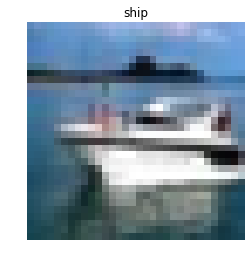

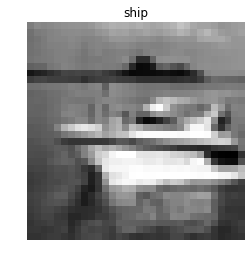

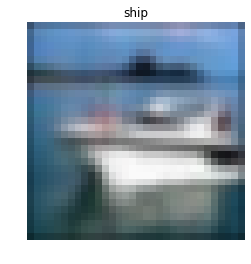

In [3]:
# get a image
images, labels = dataloader.get_batch(1)

# identical filter
conv = Conv(3, 3, 3, 3, S=1, P=1)
b = np.zeros(3)
W = np.zeros([3, 3, 3, 3])
W[0, 0, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
W[1, 1, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
W[2, 2, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

images_i, _ = conv.forward(images, {'W': W, 'b': b})

# grey filter
conv = Conv(3, 1, 3, 3, S=1, P=1)
b = np.zeros(1)
W = np.zeros([1, 3, 3, 3])
W[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

images_g, _ = conv.forward(images, {'W': W, 'b': b})

# other filter
conv = Conv(3, 3, 3, 3, S=1, P=1)
b = np.zeros(3)
W = np.zeros([3, 3, 3, 3])
W[0, 0, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]
W[1, 1, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]
W[2, 2, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]

images_u, _ = conv.forward(images, {'W': W, 'b': b})

# show image
dataloader.show_by_data(images_i[0], labels[0])
dataloader.show_by_data(images_g[0], labels[0])
dataloader.show_by_data(images_u[0], labels[0])

### Compare img2col/col2img with naive implementation

In [4]:
# get a image
images, labels = dataloader.get_batch(1)

# for conv layer
conv = Conv(3, 3, 3, 3, S=1, P=1)
conv_naive = ConvNaive(3, 3, 3, 3, S=1, P=1)
param = conv.get_init_param()

result, _ = conv.forward(images, param)
result_naive, _ = conv_naive.forward(images, param)

print('Relative error of conv layer:', check_rel_error(result , result_naive))

# for max pooling layer
pool = MaxPool(2, 2, S=2)
pool_naive = MaxPoolNaive(2, 2, S=2)

result, _ = pool.forward(images, {})
result_naive, _ = pool_naive.forward(images, {})

print('Relative error of max pooling layer:', check_rel_error(result , result_naive))


Relative error of conv layer: 5.84126541514723e-08
Relative error of max pooling layer: 0.0


### Gradient check

In [5]:
def get_init_model(hyperparams):
    return ThreeLayerConvNet((3, 32, 32), 10, hyperparams=hyperparams)

# init model
model = get_init_model({'init_scale': 1e-2, 'num_filter': 3, 'num_hidden': 5})

# gradient check
print('\nGradient check result:')
check_gradient(model, dataloader.x_train[0: 10, :], dataloader.y_train[0: 10])


Gradient check result:
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.Conv'> W 0.050183967381656196 0.05029125049431046 0.0021355139092448646
<class 'models.layers.Conv'> b -0.00011109684283638897 -0.00011109685384108416 9.905497188244501e-08
<class 'models.layers.Linear'> W -0.004729750480159112 -0.004729750484304788 8.765105063303101e-10
<class 'models.layers.Linear'> b -0.0007190430917347611 -0.0007190430697135284 3.062574872206598e-08
<class 'models.layers.Linear'> W -0.06607765239419194 -0.06607765247723513 1.2567514186686728e-09
<class 'models.layers.Linear'> b -0.10163113111083531 -0.1016311311772506 6.534935623240236e-10


### Overfit small dataset

In [7]:
# load small dataset
smallloader = DataCifar10('./datasets/cifar-10-batches-py', 
                          num_train=100, num_test=100, num_val=100)

# init model
model = get_init_model({'reg': 0., 
                        'filter_size': 7,
                        'num_filter': 32, 
                        'num_hidden': 100, 
                        'init_scale': 1e-2})

optimer = OptimerAdam({'learn_rate': 1e-3, 
                       'num_iters': 100, 
                       'batch_size': 50}, print_every=10)

# train model
optimer.train(model, smallloader)

# save model
model.save('./saves/ThreeLayerConvNet/model_small.pkl')

0 / 100 loss is 2.547440909295528
10 / 100 loss is 2.139738705253491
20 / 100 loss is 1.8529035889397492
30 / 100 loss is 0.910520787709703
40 / 100 loss is 0.2760846130619552
50 / 100 loss is 0.09646961145851185
60 / 100 loss is 0.02316438648298325
70 / 100 loss is 0.01425474453654317
80 / 100 loss is 0.006318983127294097
90 / 100 loss is 0.0037026938960400845


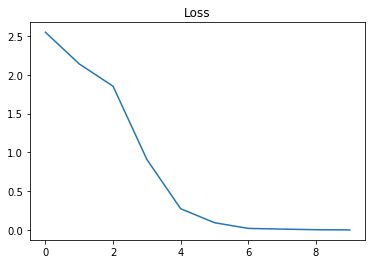

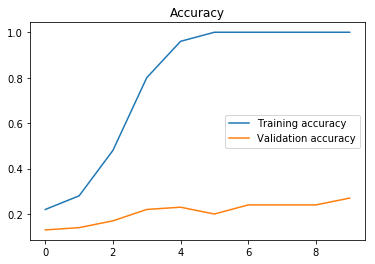

In [8]:
# plot loss curve
show_training_info(optimer)

In [12]:
# load model
model = ThreeLayerConvNet()
model.load('./saves/ThreeLayerConvNet/model_samll.pkl')

# check accuracy
scores = model.predict(smallloader.x_test)
accuracy = check_accuracy(scores, smallloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.14


# Train 3-layer convnet

In [78]:
# init model
model = get_init_model({'reg': 0.01, 
                        'filter_size': 7,
                        'num_filter': 32, 
                        'num_hidden': 500, 
                        'init_scale': 1e-3})

optimer = OptimerAdam({'learn_rate': 1e-4, 
                       'learn_rate_decay':0.98,
                       'num_iters': 10000, 
                       'batch_size': 50}, print_every=50)

# train model
optimer.train(model, dataloader)

# save model
model.save('./saves/ThreeLayerConvNet/model.pkl')

0 / 10000 loss is 2.32281057064945
50 / 10000 loss is 2.0941219279415364
100 / 10000 loss is 1.93232271399779
150 / 10000 loss is 1.6460836745952572
200 / 10000 loss is 1.7072308645416465
250 / 10000 loss is 1.6410250564017628
300 / 10000 loss is 1.6352672608441317
350 / 10000 loss is 1.4581009720005396
400 / 10000 loss is 1.7016321282169244
450 / 10000 loss is 1.7355953984010417
500 / 10000 loss is 1.496023521773752
550 / 10000 loss is 1.647927853516668
600 / 10000 loss is 1.544073694378972
650 / 10000 loss is 1.4940298197974875
700 / 10000 loss is 1.519397928673423
750 / 10000 loss is 1.5205990977614876
800 / 10000 loss is 1.4293638411167908
850 / 10000 loss is 1.679385563410499
900 / 10000 loss is 1.4572566887267835
950 / 10000 loss is 1.3846716624089812
1000 / 10000 loss is 1.2055283447453333
1050 / 10000 loss is 1.7064348435420698
1100 / 10000 loss is 1.392073447695545
1150 / 10000 loss is 1.490629907164522
1200 / 10000 loss is 1.2761077195921326
1250 / 10000 loss is 1.32090102958

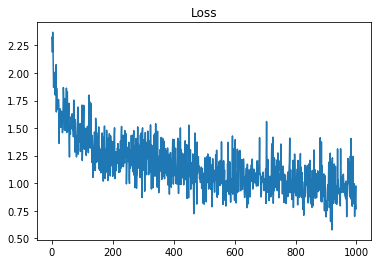

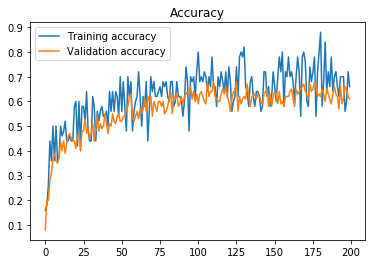

The accuracy on testing dataset is  0.607


In [79]:
# load model
model = ThreeLayerConvNet()
model.load('./saves/ThreeLayerConvNet/model.pkl')

# plot loss curve
show_training_info(optimer)

In [ ]:


# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)